In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)
data = pd.read_csv("imageFilenames.csv")
data.head()

,Unnamed: 0,totPurchaseAmt,mediumImageLink,imgFilepath
0,0,152000.0,https://photos.zillowstatic.com/p_c/IS1fwt0hhf...,images/img_0.jpg
1,1,198000.0,https://www.zillowstatic.com/static/images/nop...,no photo
2,2,130000.0,https://www.zillowstatic.com/static/images/nop...,no photo
3,3,415000.0,https://photos.zillowstatic.com/p_c/IS72penoji...,images/img_3.jpg
4,4,329900.0,https://www.zillowstatic.com/static/images/nop...,no photo


In [2]:
from PIL import Image
import numpy as np

# Want to know how we should format the height x width image data dimensions
# for inputting to a keras model
def get_size_statistics(data):
    heights = []
    widths = []
    img_count = 0
    for i, row in data.iterrows():
        if row["imgFilepath"] != "no photo" or row["imgFilepath"] != np.nan:
            try:
                imgData = np.array(Image.open(row["imgFilepath"]))
                heights.append(imgData.shape[0])
                widths.append(imgData.shape[1])
                img_count += 1
            except:
                data.at[i, "imgFilepath"] = "no photo"
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

get_size_statistics(data)

Average Height: 234.0
Max Height: 234
Min Height: 234


Average Width: 316.0
Max Width: 316
Min Width: 316


In [3]:
noPhotoIndx = data[data["imgFilepath"] == "no photo"].index 

data.drop(noPhotoIndx, inplace=True)

In [4]:
data.shape

(7907, 4)

In [5]:
IMG_SIZE = 224

def resizeAndLoadData(data):
    imageData = []
    for i, row in data.iterrows():
        img = Image.open(row["imgFilepath"])
        img = img.resize((IMG_SIZE, IMG_SIZE))
        imageData.append(np.array(img))
    data["imgData"] = imageData

resizeAndLoadData(data)

In [6]:
data.head(1)

,Unnamed: 0,totPurchaseAmt,mediumImageLink,imgFilepath,imgData
0,0,152000.0,https://photos.zillowstatic.com/p_c/IS1fwt0hhf...,images/img_0.jpg,"[[[183, 209, 237], [179, 207, 236], [169, 199,..."


In [7]:
from sklearn.model_selection import train_test_split

X = np.array(data["imgData"])
y = data["totPurchaseAmt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

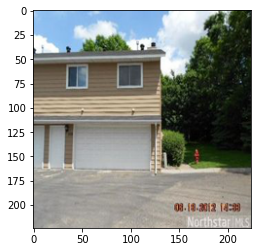

In [8]:
import matplotlib.pyplot as plt
plt.imshow(X[0])


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [10]:
from keras import applications

vggModel = Sequential()

vggModel.add(applications.VGG16(weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False))

for layer in vggModel.layers:
    layer.trainable = False

vggModel.add(Flatten())
vggModel.add(Dropout(.2))
vggModel.add(Dense(128, activation="relu"))
vggModel.add(Dense(1, activation = 'linear'))

vggModel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
vggModel.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])

In [15]:
X_train = np.array([i for i in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

vggModel.fit(X_train, y_train, batch_size=50, epochs=100, verbose=1,  validation_split=0.1)


Train on 5692 samples, validate on 633 samples
Epoch 1/100
5692/5692 [==============================] - 1322s 232ms/step - loss: 101301144045.6500 - mae: 281351.2500 - val_loss: 93411843940.7014 - val_mae: 281490.9375
Epoch 2/100
1350/5692 [======>.......................] - ETA: 15:16 - loss: 104899154071.7037 - mae: 283225.8750

KeyboardInterrupt: 

In [ ]:
X_test = np.array([i for i in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

loss, mae = vggModel.evaluate(X_test, y_test, verbose=1)

print("Loss (MSE): ", loss)
print("MAE: ", mae)